In [1]:
%pylab inline
import glob
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import dateutil.parser
import sklearn.linear_model as lm

Populating the interactive namespace from numpy and matplotlib


In [2]:
def convert(date):
    dtime = dateutil.parser.parse(date).replace(tzinfo=None)
    epoch = dtime.utcfromtimestamp(0)
    delta = dtime - epoch
    return delta.total_seconds()

In [3]:
def speed_to_pace(speed):
    return 100 / (6 * speed)

In [4]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/APE_runs_oct26-mar22"
colnames = np.array(['time', 'elevation', 'distance', 'speed', 'HR'])
Datasets_all = []
os.chdir(path)
for file in glob.glob("*.tab"):
    ds = np.genfromtxt(file, skip_header=1, delimiter='\t', converters={0: convert})
    ds[:,0] -= ds[0,0]                              # time reference set to 0
      
    if (ds[:,2].max() > 10000) == (ds[:,2].max() < 13000):
        ds = pd.DataFrame(ds,columns=colnames)
        slope = np.array([])

        for i in ds.index:
            index = np.arange(i - 3 + 1, i + 3 + 1)
            index = index[(index >= 0) & (index < len(ds))]
            dataset_part = ds[['distance','elevation']].iloc[index].dropna()

            regr = lm.LinearRegression()
            regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))

            slope = np.append(slope,100*regr.coef_)

        dataset_new = ds.drop(['elevation','HR'], axis=1)
        dataset_new['slope'] = slope

        Datasets_all.append(dataset_new)
len(Datasets_all)

7

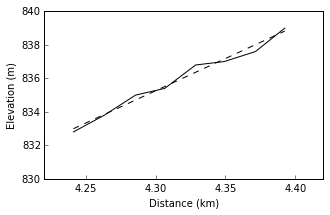

In [5]:
dataset_part = ds[['distance','elevation']].iloc[np.arange(220 - 4 + 1, 220 + 4 + 1)].dropna()
regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
y_lr = regr.predict(dataset_part.distance[:,np.newaxis])
fig = plt.figure(figsize=(5,3), dpi=72)
ax = fig.add_subplot(111)
ax.plot(dataset_part.distance/1000, dataset_part.elevation, 'k')
ax.plot(dataset_part.distance/1000, y_lr,'k--')
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylim([830, 840])
ax.set_xlim([4.22, 4.42])
ax.set_xlabel('Distance (km)')
ax.set_ylabel('Elevation (m)')
#fig.savefig('../../../Thesis/linearRegressionSlope.pdf',dpi=fig.dpi, bbox_inches='tight')

In [5]:
datasets = pd.concat(Datasets_all,ignore_index=True)
datasets.sort(columns='distance', inplace=True)
datasets.index = np.arange(len(datasets))

In [6]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST"
window_size_half = 3
os.chdir(path)
file = "feeling_bad_activity.tab"

dataset = np.genfromtxt(file, skip_header=1,delimiter='\t', converters={0: convert})
dataset[:,0] -= dataset[0,0]
dataset = pd.DataFrame(dataset,columns=colnames)
slope = np.array([])
correction_factor = np.array([])
for i in dataset.index:
    index = np.arange(i-window_size_half+1, i+window_size_half+1)
    index = index[(index >= 0) & (index < len(dataset))]
    dataset_part = dataset.iloc[index].dropna()
    regr = lm.LinearRegression()
    regr.fit(dataset_part.distance[:,np.newaxis], np.array(dataset_part.elevation))
    slope = np.append(slope,regr.coef_)
    
    if regr.coef_ > 0:
        correction_factor = np.append(correction_factor, 1 / (1 + 0.033 * regr.coef_*100))
    elif regr.coef_ < 0:
        correction_factor = np.append(correction_factor, 1 / (1 + 0.018 * regr.coef_*100))
    
validation_data = dataset.drop(['HR'], axis=1)
validation_data['slope'] = slope
validation_data['correction'] = correction_factor

distances = np.array(validation_data.distance)
distance_diffs = np.concatenate([[distances[0]], distances[1:] - distances[:len(distances)-1]])

time_runner = np.array(validation_data.time)
speed_corrected = datasets.speed.median() / validation_data.correction
time_diffs = np.concatenate([[time_runner[0]], time_runner[1:] - time_runner[:len(time_runner)-1]])
times_prediction = distance_diffs / speed_corrected
times_prediction[0] = 0
times = np.arange(len(time_runner))
rt = np.vectorize(lambda x: times_prediction[x:].sum(axis=0))
t = np.vectorize(lambda x: times_prediction[:x+1].sum(axis=0))
times_estimated_total = np.concatenate([[0], time_runner[:-1]]) + times_prediction
remaining_time = rt(times)
total_time = time_runner + remaining_time
total_predicted = t(times)

print "{0} {1:.2f} km".format(file[:-4], validation_data.distance.iloc[-1]/1000)
print "Tiempo real de carrera {}".format(dt.timedelta(seconds=validation_data.time.iloc[-1]))
print "Tiempo predicho de carrera {} ".format(dt.timedelta(seconds=round(times_prediction.sum()))),
print 'Error: {0} ({1:0.2f}%)'.format(dt.timedelta(seconds=round(abs(validation_data.time.iloc[-1] - times_prediction.sum()))),
                                   abs((validation_data.time.iloc[-1] - times_prediction.sum())/validation_data.time.iloc[-1] * 100))
validation_data.head()

feeling_bad_activity 10.01 km
Tiempo real de carrera 0:54:43
Tiempo predicho de carrera 0:52:13  Error: 0:02:30 (4.58%)


,time,elevation,distance,speed,slope,correction
0,0,746.599976,2.730000,2.986,0.131653,0.697128
1,1,746.799988,5.120000,2.725,0.143909,0.678012
2,5,748.200012,14.970000,2.743,0.146122,0.674671
3,6,748.400024,16.940001,2.669,0.140994,0.682463
4,14,751.400024,36.439999,2.538,0.167563,0.643933


In [7]:
if file == 'test_activity.tab':
    test = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Speed corrected': validation_data.speed / validation_data.correction,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    test.to_pickle('cs2_test')
    print file
    print test.head()

elif file == 'feeling_bad_activity.tab':
    feelingBad = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Speed corrected': validation_data.speed / validation_data.correction,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    feelingBad.to_pickle('cs2_feelingBad')
    print file
    print feelingBad.head()

elif file == 'Morat_Fribourg2014.tab':
    moratFribourg = pd.DataFrame({'Distance': distances,
                              '$\Delta{}d$': distance_diffs,
                              'Elevation': validation_data.elevation,
                              'Speed': validation_data.speed,
                              'Speed corrected': validation_data.speed / validation_data.correction,
                              'Slope (%)': validation_data.slope * 100,
                              'Time Runner': time_runner,
                              '$\Delta{}t^{est}$': times_prediction,
                              '$\Delta{}t^{real}$': time_diffs,
                              'Remaining Time': remaining_time,
                              'Total time': total_time,
                              'Total predicted': total_predicted,
                              'Time estimated': times_estimated_total})
    moratFribourg.to_pickle('cs2_morFrib')
    print file
    print moratFribourg.head()

feeling_bad_activity.tab
   $\Delta{}d$  $\Delta{}t^{est}$  $\Delta{}t^{real}$   Distance   Elevation  \
0     2.730000           0.000000                   0   2.730000  746.599976   
1     2.390000           0.510860                   1   5.120000  746.799988   
2     9.850000           2.095053                   4  14.970000  748.200012   
3     1.970000           0.423850                   1  16.940001  748.400024   
4    19.499998           3.958605                   8  36.439999  751.400024   

   Remaining Time  Slope (%)  Speed  Speed corrected  Time Runner  \
0     3132.679428  13.165335  2.986         4.283286            0   
1     3132.679428  14.390902  2.725         4.019102            1   
2     3132.168568  14.612244  2.743         4.065686            5   
3     3130.073514  14.099449  2.669         3.910837            6   
4     3129.649664  16.756253  2.538         3.941403           14   

   Time estimated  Total predicted   Total time  
0        0.000000         0.0

In [2]:
path = "/Users/aRa/OneDrive/Documentos/ERASMUS/PFC/SmartCoach/Running_w_HR/TEST/"
os.chdir(path)

test = pd.read_pickle('cs2_test')
feelingBad = pd.read_pickle('cs2_feelingBad')
moratFribourg = pd.read_pickle('cs2_morFrib')

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import ImageGrid

def add_inner_title(ax, title, loc, size=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    from matplotlib.patheffects import withStroke
    if size is None:
        size = dict(size=plt.rcParams['legend.fontsize'])
    at = AnchoredText(title, loc=loc, prop=size,
                      pad=0., borderpad=0.5,
                      frameon=False, **kwargs)
    ax.add_artist(at)
    at.txt._text.set_path_effects([withStroke(foreground="w", linewidth=3)])
    return at

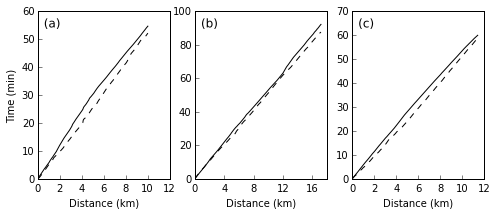

In [4]:
# REAL TIME VS PREDICTED TIME
fig = plt.figure(figsize=(8,3), dpi=72)
ax1 = fig.add_subplot(111)
divider = make_axes_locatable(ax1)
ax2 = divider.new_horizontal(size="100%", pad=0.35)
ax3 = divider.new_horizontal(size="100%", pad=0.35)

fig1 = ax1.get_figure()
fig1.add_axes(ax2)
fig1.add_axes(ax3)

ax1.plot(feelingBad['Distance']/1000, feelingBad['Time Runner']/60, 'k', label='Race time')
ax1.plot(feelingBad['Distance']/1000, feelingBad['Total predicted']/60, 'k--', label='Predicted time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Time Runner']/60, 'k', label='Race time')
ax2.plot(moratFribourg['Distance']/1000, moratFribourg['Total predicted']/60, 'k--', label='Predicted time')
ax3.plot(test['Distance']/1000, test['Time Runner']/60, 'k', label='Race time')
ax3.plot(test['Distance']/1000, test['Total predicted']/60, 'k--', label='Predicted time')
ax1.set_ylabel('Time (min)')

for ax, im_title in zip([ax1, ax2, ax3], ["(a)", "(b)", "(c)"]):
        t = add_inner_title(ax, im_title, loc=2)
        t.patch.set_ec("none")
        t.patch.set_alpha(0.5)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel('Distance (km)')
ax2.set_xticks(ax2.get_xticks()[::2])   
plt.draw()
plt.show()
fig.savefig('../../../Thesis/images/TimeRunnerVsTimePredictedCS2.pdf',bbox_inches='tight', dpi=fig.dpi)

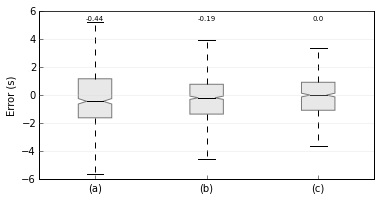

In [11]:
# BOXPLOTS ERRORES DE PREDICCIÓN
errorFeelingBad = feelingBad['$\Delta{}t^{est}$'] - feelingBad['$\Delta{}t^{real}$']
errorMoratFrib = moratFribourg['$\Delta{}t^{est}$'] - moratFribourg['$\Delta{}t^{real}$'] 
errorTest = test['$\Delta{}t^{est}$'] - test['$\Delta{}t^{real}$']
errors = [errorFeelingBad, errorMoratFrib, errorTest]
numBoxes = len(errors)
pos = np.arange(numBoxes)+1

fig = plt.figure(figsize=(6,3), dpi=72)
ax = fig.add_subplot(111)
bp = ax.boxplot(errors, labels=['(a)', '(b)', '(c)'], patch_artist=True, sym='', notch=True)

plt.setp(bp['boxes'], color='black', facecolor = 'lightgrey', alpha=0.5)
plt.setp(bp['medians'], color='black')
plt.setp(bp['whiskers'], color='black')
plt.setp(bp['caps'], color='black')

top = ax.get_ylim()[1]*0.89
medians = [np.nanmedian(i) for i in errors]
upperLabels = [str(np.round(s, 2)) for s in medians]

for tick,label in zip(range(numBoxes),ax.get_xticklabels()):
    ax.text(pos[tick], top, upperLabels[tick], horizontalalignment='center', size='x-small', color='black')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.set_ylabel('Error (s)')
fig.savefig('../../../Thesis/images/bxplotErrorsCS2.pdf',bbox_inches='tight', dpi=fig.dpi)

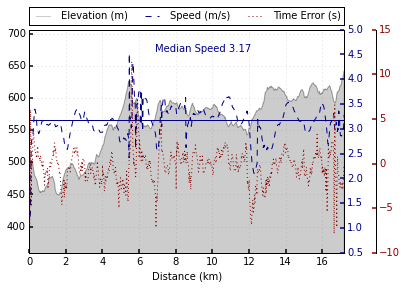

In [11]:
# GRAFICA DEL ERROR DE PREDICCION CON ELEVACION Y VELOCIDAD
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.itervalues():
        sp.set_visible(False)
        
fig, host = plt.subplots(figsize=(7,4), dpi=72)
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes", 1.1))
make_patch_spines_invisible(par2)
par2.spines["right"].set_visible(True)

p1, = host.plot(moratFribourg['Distance'], moratFribourg['Elevation'], color='k', label='Elevation (m)',alpha=0.2)
host.fill_between(moratFribourg['Distance'], 0, moratFribourg['Elevation'], color='k', alpha=0.2)
p2, = par1.plot(moratFribourg['Distance'], moratFribourg['Speed'], color='DarkBlue', linestyle='--', label='Speed (m/s)')
p2.axes.axhline(y=datasets.speed.median(), color='DarkBlue')
p3, = par2.plot(moratFribourg['Distance'], moratFribourg['$\Delta{}t^{est}$'] - moratFribourg['$\Delta{}t^{real}$'], 
                color='DarkRed', linestyle=':', label=r'Time Error (s)')

host.set_xlim([moratFribourg['Distance'].min(), moratFribourg['Distance'].max()])
host.set_xticklabels([np.str(int(i)) for i in host.get_xticks()/1000])
host.set_ylim([moratFribourg['Elevation'].min()*0.8, moratFribourg['Elevation'].max()*1.1])

host.set_xlabel(r'Distance (km)')

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)
host.get_xaxis().tick_bottom()
host.legend((p1, p2, p3),(p1.get_label(), p2.get_label(), p3.get_label()),
           bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=3, mode="expand", borderaxespad=0.,
            fontsize=10)
host.grid(alpha=0.25)
host.text(0.4*host.get_xlim()[-1],0.95*host.get_ylim()[-1],
          'Median Speed {:.2f}'.format(datasets.speed.median()), color='DarkBlue', fontsize=10)
fig.savefig("../../../Thesis/images/errorCS2MorFrib.pdf", bbox_inches='tight', dpi=fig.dpi)

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
im=ax1.plot(distances,validation_data.elevation,'k',zorder=1)
ax1.set_title('Elevation',fontsize=16,y=1.02)
ax1.set_ylabel('Elevation ['r'$m$]')
ax1.grid(axis='y', alpha=0.5)
ax1.set_yticks(ax1.get_yticks()[::2])
plt.setp(ax1.get_xticklabels(), visible=False)

ax2 = fig.add_subplot(212)
ax2.plot(distances, times_prediction_total,c='black',zorder=1)
#ax2.scatter(laps,laps_times_total-0.1,c='white',zorder=1,linewidth=0)
ax2.axhline(y=time_runner[-1]/60, color='magenta')
ax2.text(0.95,0.95,'Real time {}'.format(dt.timedelta(seconds=time_runner[-1])), 
         verticalalignment='top', horizontalalignment='right', transform=ax2.transAxes,
         color='magenta', fontsize=14)
ax2.set_title('Estimated time',fontsize=16,y=1.02)
ax2.set_xlabel('Distance ['r'$m$]')
ax2.set_ylabel('Time ['r'$min$]')
ax2.grid(alpha=0.5)
ax2.set_ylim([time_min - (time_max-time_min)/2., time_max + (time_max-time_min)/2])
ax2.set_yticks(ax2.get_yticks()[::2])
ax2.set_xticks(np.arange(-2000,14000, 2000))
ax1.set_xlim(ax2.get_xlim())
plt.tight_layout()